# Switzer method demo
This methodology has not completed WRI's review process and should not be used for any purpose.

Direct questions to Ted Wong (ted.wong@wri.org).

## Problem: How to estimate future probability distributions of climate-hazard indicators
* Data source: climate simulations
    * These are global rasters of CMIP6 simulations. Outputs include daily maxtemp, mintemp, precip, and humidity for every day in years 1950-2100.
    * Downscale product is [NEX-GDDP-CMIP6](https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6). Resolution is 0.25 degrees, or approx. 25 km.
* Additional data: satellite observations
    * This is the [ERA5 reanalysis product](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5), which provides similar variables and resolution for 1940-present.
    * This dataset is not used in the proposed methodology below, but it is available if useful.
    
* Using the simulated variables, for any year we can calculate numerous climate-hazard indicators for any location. Example indicators:
     * Number of days in a year with maxtemp > 35C
     * Duration of longest uninterrupted dryspell in a year
     * Number of degree-days between final frost and first frost in a year
* For a given location and future year, we would like to estimate either...
    * Probability distributions of indicator magnitudes
    * or the probability that the indicator magnitude exceeds a given threshold
* Considerations
    * Ease of calculation
        * Use cases include implementation a a web application for on-demand calculation, and precalculation of large-area rasters. We hope to use methods that lend themselves well to parallelization.
        * We would like to be able to assess the quality of our probability estimates.

## Proposed solution: Random sampling of Poisson rate parameters

* Count exceedance events over a historical interval in both a model and an observation dataset. Also count future exceedance events in one of the climate models.
* Assume counts are Poisson-distributed.
* Using Jeffries prior, the posterior distribution of Poisson rate parameters is Gamma-distributed with shape parameter equal to the event count plus one-half.
* Different models have biases. We'll use the historical observations and historical model data to calibrate each model's future event count. Define a calibration function as follows:
    * Take 10,000 draws from the Gamma distribution using the count from the historical observation dataset as shape parameter. Call these gH_draws.
    * Similar for the historical modeled data: 10,000 draws from Gamma($\alpha$ = historical model count). Call these gHM_draws.
    * Order gH_draws and gHM_draws by size.
    * For j = 1...1000, let X(j,gH) and X(j,gHM) denote the j-th largest value of gH_draws and gHM_draws. Let n(j,gHM) denote the number of gHM sample values that are smaller than X(j,gH). Then the calibrated value of X(j,gHM) is X(n(j),gHM), for j = 1..1000.
    * This defines a mapping from j --> n(j). This mapping is the calibration function.
* Apply the calibration function to gFM_draws to get calibrated gFM_draws, or cgFM_draws. This is the calibrated distribution of Poisson rate parameters.
* Uniformly draw 1000 Poisson parameters from cgFM_draws. Use these 1000 drawn Poisson parameters to generate 1000 Poisson distributions. From each, draw one future exceedance event count.
* Report the mean of the event-count distribution, and display the distribution.
* Do all this for each model and report results separately. Maybe also report the mean value. (Or evaluate models by the distance between gH and gHM, and use only the best model.)




# Demo implementation

### Import libraries set authentication credentials, etc.

In [1]:
import ee
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import datetime, calendar

plt.style.use("seaborn-darkgrid")

ee.Authenticate()
ee.Initialize()

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Enter verification code: 4/1AWtgzh6mdIeY_B3RJMltalZbwKBl49kOobBy36hUoLTC62Y9zd9gExA34ws

Successfully saved authorization token.


--------------------------
### Select CMIP6 models and define a location and future year of interest

In [273]:
LEAPLENGTH = {'UKESM1-0-LL': 360,
 'NorESM2-MM': 365,
 'NorESM2-LM': 365,
 'MRI-ESM2-0': 366,
 'MPI-ESM1-2-LR': 366,
 'MPI-ESM1-2-HR': 366,
 'MIROC6': 366,
 'MIROC-ES2L': 366,
 'KIOST-ESM': 365,
 'KACE-1-0-G': 360,
 'IPSL-CM6A-LR': 366,
 'INM-CM5-0': 365,
 'INM-CM4-8': 365,
 'HadGEM3-GC31-MM': 360,
 'HadGEM3-GC31-LL': 360,
 'GFDL-ESM4': 365,
 'GFDL-CM4_gr2': 365,
 'GFDL-CM4': 365,
 'FGOALS-g3': 365,
 'EC-Earth3-Veg-LR': 366,
 'EC-Earth3': 366,
 'CanESM5': 365,
 'CNRM-ESM2-1': 366,
 'CNRM-CM6-1': 366,
 'CMCC-ESM2': 365,
 'CMCC-CM2-SR5': 365,
 'BCC-CSM2-MR': 365,
 'ACCESS-ESM1-5': 366,
 'ACCESS-CM2': 366,
 'TaiESM1': 365,
 'ERA5': 366
}

EXCLUDED_MODELS = ['TaiESM1', 'ERA5']    # TaiESM1 model has major known biases

#MODELS = [i for i in LEAPLENGTH.keys() if not i in EXCLUDED_MODELS]
MODELS = ['ACCESS-CM2']

INITIAL_LATLON = (22.75, 87.82)
INITIAL_WINDOW = ('04-15', '09-10')
HIST_START = 1995
HIST_END = 2015
FUTURE_START = 2050
FUTURE_END = 2070


In [274]:
MODELS = ['ACCESS-CM2']

--------------------------------------
### Define indicator of interest
This indicator counts the number of days within a given window in the year with maximum temperature >= 35C

In [239]:
indicators = {
    'dtg34': {
            'name': 'dtg34',
            'greaterthan': True,
            'nex_varname': 'tasmax',
            'era5_varname': 'maximum_2m_air_temperature',
            'range': [1, 365, 1],
            'nex_multiply': 1,
            'nex_add': -273.15,
            'era5_multiply': 1,
            'era5_add': -273.15,
            'function': lambda windowdata: np.sum(windowdata >= 35, axis=1)
    } 
}


def get_mags(lat, lon, window, start_year, end_year, model, indicator, scenario='ssp585'):

# Returns array of event counts, one for each year
    
    def d2j(datestring):
        d = datetime.date.fromisoformat(datestring)
        jday = d.timetuple().tm_yday
        if calendar.isleap(d.year) and jday > 59:
            jday -= 1
        return jday
    
    if model == 'ERA5':
        varname = indicator['era5_varname']
        is_forecast = varname == "precipitation_amount_1hour_Accumulation"
        dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
        mult = indicator['era5_multiply']
        add = indicator['era5_add']
    else:
        varname = indicator['nex_varname']
        dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model))
        mult = indicator['nex_multiply']
        add = indicator['nex_add']
    indicator_fxn = indicator['function']
    gee_geom = ee.Geometry.Point((lon, lat))

    allyears = []
    for year in range(start_year, end_year):
        window_start = datetime.datetime.strptime('{0}-{1}'.format(year, window[0]), '%Y-%m-%d')
        window_end_plusone = datetime.datetime.strptime('{0}-{1}'.format(year, window[1]), '%Y-%m-%d') + datetime.timedelta(days=1) 
        data_vars = dataset.select(varname).filter(ee.Filter.date(window_start.strftime('%Y-01-01'), window_end_plusone.strftime('%Y-12-31')))
        if model != 'ERA5':
            data_vars = data_vars.filter(ee.Filter.eq('scenario', [scenario, 'historical'][int(year < 2015)]))
        print('Collecting values {0} {1}'.format(model, year))
        yeardata = pd.DataFrame(data_vars.getRegion(gee_geom, 25000, 'epsg:4326').getInfo())[4][1:]
        allyears.append(yeardata[d2j(window_start.strftime('%Y-%m-%d'))+1: d2j(window_end_plusone.strftime('%Y-%m-%d'))+1])
    return indicator_fxn((np.array(allyears) * mult) + add)

### Get exceedance event counts

* _hobs_ is event count for historical years from observation dataset
* _hmod_ is event count for historical years from model dataset
* _fmod_ is event count for future years from model dataset

In [285]:
hobs = get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, HIST_START, HIST_END, 'ERA5', indicators['dtg34'])
hmod = get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, HIST_START, HIST_END, MODELS[0], indicators['dtg34'])
fmod = get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, FUTURE_START, FUTURE_END, MODELS[0], indicators['dtg34'])

### Draw gamma-distributed Poisson rate parameters

Each drawn from Gamma($\alpha$ = event_count + half, $\beta$ = 1)

In [276]:
gH_draws = np.random.gamma(shape=hobs.mean() + 0.5, size=10000)
gHM_draws = np.random.gamma(shape=hmod.mean() + 0.5, size=10000)
gFM_draws = np.random.gamma(shape=fmod.mean() + 0.5, size=10000)

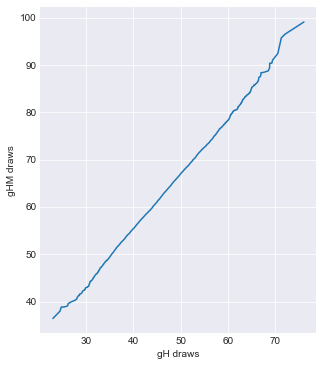

In [310]:
# This is a P-P plot of the Poisson parameters. The plot is not important for the calculation.

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.set_aspect('equal')
plt.plot(np.sort(gH_draws), np.sort(gHM_draws))
plt.xlabel('gH draws')
plt.ylabel('gHM draws')
plt.show()

### Define the calibration function

1. Sort gH and gHM by increasing size.
2. For each jth value of gHM...
    1. Find the jth value of gH. Call it _source_value_.
    2. Find the position in the gHM's where the value is greater than or equal to _source_value_.
    3. Record that position in the jth position of an array.
    
The resulting array is an array of indices. Reordering gHM or gFM by these indices, yields a calibrated distribution cgHM or cgFM.

In [292]:
def calibration_function(hist_obs, hist_mod):
    new_indices = []
    source = np.sort(hist_obs)
    target= np.sort(hist_mod)
    source[-1] = target[-1]  # when target[i] greater than all source values, return max index
    for target_idx, target_value in enumerate(target):
        source_value = source[target_idx]
        new_indices.append(np.argmax(target >= source_value))
    return new_indices

Apply the calibration function to the future draws to get a distribution of calibrated future Poisson parameters.

In [293]:
cgFM_draws = gFM_draws[calibration_function(gH_draws, gHM_draws)]

{'whiskers': [<matplotlib.lines.Line2D at 0x1e0838a45b0>,
 'caps': [<matplotlib.lines.Line2D at 0x1e0838a4b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e0838a43d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e0838b3130>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e0838b3400>],
 'means': []}

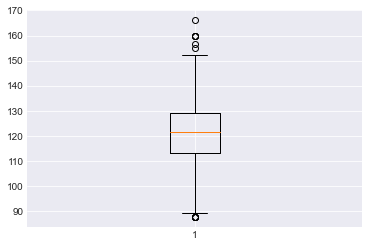

In [294]:
# This is a boxplot of the calibrated Poisson parameters. The boxplot is not important for the calculation.

plt.boxplot(cgFM_draws)

### Draw future event counts from Poisson distributions

* Draw 1000 Poisson parameters from cgFM_draws
* From each drawn parameter, generate a Poisson distribution
* Draw one future event count from each Poisson distribution

In [295]:
uniform_draws = np.random.randint(low=0, high=10000, size=1000)
cpFM_draws = np.random.poisson(lam=cgFM_draws[uniform_draws], size=1000)

### Visualize the distribution of future event counts

{'whiskers': [<matplotlib.lines.Line2D at 0x1e0838d9760>,
 'caps': [<matplotlib.lines.Line2D at 0x1e0838d9d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e0838f9370>],
 'medians': [<matplotlib.lines.Line2D at 0x1e08390a2e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e08390a5b0>],
 'means': []}

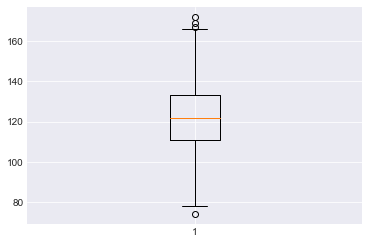

In [296]:
plt.boxplot(cpFM_draws)

In [297]:
stats.describe(cpFM_draws)

DescribeResult(nobs=1000, minmax=(74, 172), mean=121.831, variance=249.77621521521522, skewness=0.0499266002122842, kurtosis=0.04696408663398177)